In [1]:
import warnings
warnings.filterwarnings("ignore")

1. #### Import Data

In [3]:
!ls -l speed-limit-signs

ls: speed-limit-signs: No such file or directory


In [4]:
from zipfile import ZipFile
zip = ZipFile(r"speed-limit-signs.zip")
zip.extractall(".")

In [5]:
!ls -l speed-limit-signs

total 8
drwxr-xr-x  81 gracialukelo  staff  2592 23 Jun 11:09 0
drwxr-xr-x  83 gracialukelo  staff  2656 23 Jun 11:09 1
drwxr-xr-x  70 gracialukelo  staff  2240 23 Jun 11:09 2
drwxr-xr-x  55 gracialukelo  staff  1760 23 Jun 11:09 3
drwxr-xr-x  43 gracialukelo  staff  1376 23 Jun 11:09 4
drwxr-xr-x  59 gracialukelo  staff  1888 23 Jun 11:09 5
-rw-r--r--   1 gracialukelo  staff   380 23 Jun 11:09 README.md


In [7]:
!cat -l speed-limit-signs/README.md

Data extracted from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

From http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip just the samples for the speed limit signs 

## Format

https://en.wikipedia.org/wiki/Netpbm_format

Can be previewed on a Mac and be processed by http://scikit-image.org/

## Labels
- 0: 30
- 1: 50
- 2: 70
- 3: 80
- 4: 100
- 5: 120

In [9]:
import os
from skimage import io
import numpy as np

In [19]:
from skimage.transform import resize

def resize_image(image, target_shape):
    return resize(image, target_shape, mode='reflect', anti_aliasing=True)

In [20]:
print(os.listdir('./'))

['.DS_Store', 'traffic_sign_classification.ipynb', 'speed-limit-signs.zip', '__MACOSX', 'speed-limit-signs', '.ipynb_checkpoints']


In [21]:
ROOT_PATH = "./"
data_dir = os.path.join(ROOT_PATH, "speed-limit-signs")
type = ".ppm"

# Get all subdirectories of data_dir. Each represents a label.
directories = [d for d in os.listdir(data_dir) 
                if os.path.isdir(os.path.join(data_dir, d))]
# Loop through the label directories and collect the data in
# two lists, labels and images.
labels = []
images = []
for d in directories:
    label_dir = os.path.join(data_dir, d)
    file_names = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(type)]
    # For each label, load its images, resize them to a common shape, and add them to the images list.
    # Also, add the label number (i.e., directory name) to the labels list.
    for f in file_names:
        image = io.imread(f)
        # Resize the image to a common shape (e.g., 64x64). Adjust this size as needed.
        resized_image = resize_image(image, target_shape=(64, 64))
        images.append(resized_image)
        labels.append(int(d))

images, labels = np.array(images), np.array(labels)

In [23]:
import matplotlib.pyplot as plt

%matplotlib inline

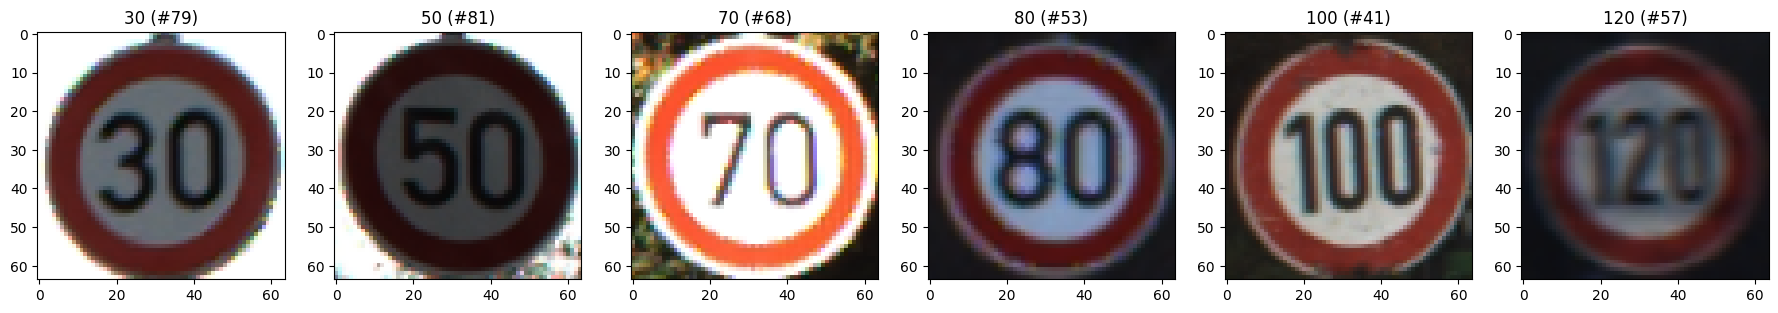

In [29]:
label_names = ['30', '50', '70', '80', '100', '120']

plt.figure(figsize=(30, 15))

unique_values, counts = np.unique(labels, return_counts=True)
classes = len(unique_values)

i = 1
for label in unique_values:
    # Pick the first image for each label.
    image = images[np.where(labels == label)[0][0]]
    plt.subplot(1, 8, i)
    plt.title("{0} (#{1})".format(label_names[label], counts[label]))
    i += 1
    plt.imshow(image)
plt.show()

2. #### Model architecture

In [37]:
image_64 = np.array([resize(image, (64, 64)) for image in images])
image_64.shape

(379, 64, 64, 3)

In [38]:
from tensorflow.keras.utils import to_categorical

X = np.array(image_64)
y = np.array(labels)

# One hot encoding 
num_categories = 6
y = to_categorical(y, num_categories)

X.shape, y.shape

((379, 64, 64, 3), (379, 6))

In [51]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization

In [63]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), activation="relu", padding='same', input_shape=(64, 64, 3)))
model.add(Conv2D(64, kernel_size=(3,3), activation="relu", padding='same'))
model.add(Conv2D(64, kernel_size=(3,3), activation="relu", padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.6))

model.add(Conv2D(128, kernel_size=(3,3), activation="relu", padding='same'))
model.add(Conv2D(182, kernel_size=(3,3), activation="relu", padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.6))


model.add(Conv2D(256, kernel_size=(3,3), activation="relu", padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.6))


model.add(Flatten())
model.add(Dense(256, activation="relu"))

model.add(Dropout(0.6))

model.add(Dense(6, activation='softmax'))
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 32, 32, 182)    │       209,846 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 16, 182)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 16, 16, 182)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 16, 16, 256)    │       419,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,975,036 (18.98 MB)

 Trainable params: 4,975,036 (18.98 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, y_train.shape

((303, 64, 64, 3), (303, 6))

In [67]:
%time history = model.fit(X_train, y_train, epochs=500, validation_split=0.3)

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 493ms/step - accuracy: 0.3028 - loss: 1.6667 - val_accuracy: 0.2308 - val_loss: 1.7737
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 472ms/step - accuracy: 0.3257 - loss: 1.7007 - val_accuracy: 0.2308 - val_loss: 1.7065
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 480ms/step - accuracy: 0.2264 - loss: 1.6869 - val_accuracy: 0.2527 - val_loss: 1.7494
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 478ms/step - accuracy: 0.3620 - loss: 1.6561 - val_accuracy: 0.1758 - val_loss: 1.7777
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 485ms/step - accuracy: 0.2578 - loss: 1.7091 - val_accuracy: 0.2857 - val_loss: 1.7276
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 475ms/step - accuracy: 0.3437 - loss: 1.6289 - val_accuracy: 0.2088 - val_loss: 1.7695
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 471ms/step - accuracy: 0.2508 - loss: 1.7254 - val_accuracy: 0.2418 - val_loss: 1.7726
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 470ms/step - accuracy: 0.3226 - loss: 1.6609 - val_accuracy: 0.3077 - v

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 476ms/step - accuracy: 0.8098 - loss: 0.5364 - val_accuracy: 0.8462 - val_loss: 0.4719
Epoch 52/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 472ms/step - accuracy: 0.8959 - loss: 0.3579 - val_accuracy: 0.8462 - val_loss: 0.4399
Epoch 53/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 478ms/step - accuracy: 0.8335 - loss: 0.5074 - val_accuracy: 0.8352 - val_loss: 0.4166
Epoch 54/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - accuracy: 0.9008 - loss: 0.3050 - val_accuracy: 0.8791 - val_loss: 0.3796
Epoch 55/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 558ms/step - accuracy: 0.9198 - loss: 0.2449 - val_accuracy: 0.8791 - val_loss: 0.3191
Epoch 56/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 495ms/step - accuracy: 0.8428 - loss: 0.4103 - val_accuracy: 0.9121 - val_loss: 0.3264
Epoch 57/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step - accuracy: 0.8995 - loss: 0.3978 - val_accuracy: 0.9231 - val_loss: 0.2849
Epoch 58/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - accuracy: 0.8892 - loss: 0.3313 - val_accuracy: 0.9011 - val_lo

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 505ms/step - accuracy: 0.9744 - loss: 0.0596 - val_accuracy: 0.9121 - val_loss: 0.2885
Epoch 102/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 497ms/step - accuracy: 0.9638 - loss: 0.0856 - val_accuracy: 0.9451 - val_loss: 0.2203
Epoch 103/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 526ms/step - accuracy: 0.9769 - loss: 0.0781 - val_accuracy: 0.9451 - val_loss: 0.2067
Epoch 104/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 509ms/step - accuracy: 0.9629 - loss: 0.0816 - val_accuracy: 0.9451 - val_loss: 0.2815
Epoch 105/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - accuracy: 0.9897 - loss: 0.0807 - val_accuracy: 0.9451 - val_loss: 0.1922
Epoch 106/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 495ms/step - accuracy: 0.9879 - loss: 0.0571 - val_accuracy: 0.8901 - val_loss: 0.2609
Epoch 107/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 520ms/step - accuracy: 0.9780 - loss: 0.0519 - val_accuracy: 0.9451 - val_loss: 0.2669
Epoch 108/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 489ms/step - accuracy: 0.9856 - loss: 0.0494 - val_accuracy: 0.9560 -

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 501ms/step - accuracy: 0.9770 - loss: 0.0646 - val_accuracy: 0.9560 - val_loss: 0.1970
Epoch 152/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 502ms/step - accuracy: 0.9938 - loss: 0.0166 - val_accuracy: 0.9451 - val_loss: 0.1950
Epoch 153/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - accuracy: 0.9905 - loss: 0.1029 - val_accuracy: 0.9560 - val_loss: 0.1756
Epoch 154/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - accuracy: 0.9913 - loss: 0.1938 - val_accuracy: 0.9451 - val_loss: 0.2001
Epoch 155/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 512ms/step - accuracy: 0.9705 - loss: 0.0681 - val_accuracy: 0.9451 - val_loss: 0.1655
Epoch 156/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 494ms/step - accuracy: 0.9929 - loss: 0.0312 - val_accuracy: 0.9121 - val_loss: 0.2456
Epoch 157/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - accuracy: 0.9746 - loss: 0.1120 - val_accuracy: 0.9341 - val_loss: 0.2461
Epoch 158/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 496ms/step - accuracy: 1.0000 - loss: 0.0101 - val_accuracy: 0.9451 -

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 502ms/step - accuracy: 0.9737 - loss: 0.1234 - val_accuracy: 0.9670 - val_loss: 0.2210
Epoch 202/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - accuracy: 0.9925 - loss: 0.0127 - val_accuracy: 0.9451 - val_loss: 0.1790
Epoch 203/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - accuracy: 0.9902 - loss: 0.0330 - val_accuracy: 0.9780 - val_loss: 0.1381
Epoch 204/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 507ms/step - accuracy: 0.9671 - loss: 0.0879 - val_accuracy: 0.9231 - val_loss: 0.2463
Epoch 205/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - accuracy: 0.9847 - loss: 0.0681 - val_accuracy: 0.9341 - val_loss: 0.2526
Epoch 206/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 497ms/step - accuracy: 0.9624 - loss: 0.1043 - val_accuracy: 0.9451 - val_loss: 0.2256
Epoch 207/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 497ms/step - accuracy: 0.9428 - loss: 0.3257 - val_accuracy: 0.9560 - val_loss: 0.2695
Epoch 208/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - accuracy: 0.9834 - loss: 0.0571 - val_accuracy: 0.9560 -

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 477ms/step - accuracy: 1.0000 - loss: 3.5821e-04 - val_accuracy: 0.9670 - val_loss: 0.2534
Epoch 252/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 476ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9670 - val_loss: 0.2444
Epoch 253/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 476ms/step - accuracy: 1.0000 - loss: 0.0087 - val_accuracy: 0.9670 - val_loss: 0.1967
Epoch 254/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 475ms/step - accuracy: 0.9974 - loss: 0.0036 - val_accuracy: 0.9670 - val_loss: 0.1878
Epoch 255/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 488ms/step - accuracy: 1.0000 - loss: 5.0958e-04 - val_accuracy: 0.9670 - val_loss: 0.1973
Epoch 256/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 476ms/step - accuracy: 1.0000 - loss: 0.0085 - val_accuracy: 0.9780 - val_loss: 0.1985
Epoch 257/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 479ms/step - accuracy: 1.0000 - loss: 1.3156e-04 - val_accuracy: 0.9780 - val_loss: 0.2019
Epoch 258/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 478ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accura

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 501ms/step - accuracy: 1.0000 - loss: 0.0093 - val_accuracy: 0.9670 - val_loss: 0.2086
Epoch 302/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 509ms/step - accuracy: 1.0000 - loss: 0.0071 - val_accuracy: 0.9560 - val_loss: 0.1886
Epoch 303/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 506ms/step - accuracy: 0.9893 - loss: 0.0165 - val_accuracy: 0.9560 - val_loss: 0.1842
Epoch 304/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 501ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9560 - val_loss: 0.1912
Epoch 305/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 506ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 0.9560 - val_loss: 0.2302
Epoch 306/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 501ms/step - accuracy: 0.9946 - loss: 0.0176 - val_accuracy: 0.9670 - val_loss: 0.1976
Epoch 307/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - accuracy: 0.9893 - loss: 0.0300 - val_accuracy: 0.9560 - val_loss: 0.2183
Epoch 308/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - accuracy: 0.9800 - loss: 0.0492 - val_accuracy: 0.9451 -

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 502ms/step - accuracy: 0.9974 - loss: 0.0102 - val_accuracy: 0.9670 - val_loss: 0.2368
Epoch 352/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 512ms/step - accuracy: 0.9964 - loss: 0.0156 - val_accuracy: 0.9670 - val_loss: 0.2514
Epoch 353/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - accuracy: 0.9915 - loss: 0.0250 - val_accuracy: 0.9560 - val_loss: 0.3374
Epoch 354/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - accuracy: 0.9982 - loss: 0.0092 - val_accuracy: 0.9560 - val_loss: 0.3592
Epoch 355/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 499ms/step - accuracy: 0.9982 - loss: 0.0069 - val_accuracy: 0.9451 - val_loss: 0.3567
Epoch 356/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 518ms/step - accuracy: 0.9857 - loss: 0.0197 - val_accuracy: 0.9560 - val_loss: 0.3272
Epoch 357/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 507ms/step - accuracy: 0.9988 - loss: 0.0047 - val_accuracy: 0.9670 - val_loss: 0.2443
Epoch 358/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 504ms/step - accuracy: 0.9896 - loss: 0.0222 - val_accuracy: 0.9670 -

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 687ms/step - accuracy: 0.9937 - loss: 0.0128 - val_accuracy: 0.9560 - val_loss: 0.2809
Epoch 402/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 609ms/step - accuracy: 1.0000 - loss: 0.0105 - val_accuracy: 0.9451 - val_loss: 0.3657
Epoch 403/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 503ms/step - accuracy: 0.9982 - loss: 0.0229 - val_accuracy: 0.9451 - val_loss: 0.4243
Epoch 404/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - accuracy: 0.9963 - loss: 0.0231 - val_accuracy: 0.9560 - val_loss: 0.4222
Epoch 405/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 504ms/step - accuracy: 1.0000 - loss: 2.5347e-04 - val_accuracy: 0.9451 - val_loss: 0.4677
Epoch 406/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 527ms/step - accuracy: 0.9874 - loss: 0.1516 - val_accuracy: 0.9560 - val_loss: 0.3767
Epoch 407/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 496ms/step - accuracy: 0.9913 - loss: 0.0159 - val_accuracy: 0.9451 - val_loss: 0.3337
Epoch 408/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 519ms/step - accuracy: 1.0000 - loss: 0.0092 - val_accuracy: 0.95

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 485ms/step - accuracy: 0.9896 - loss: 0.0392 - val_accuracy: 0.9341 - val_loss: 0.2544
Epoch 452/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 483ms/step - accuracy: 0.9876 - loss: 0.0652 - val_accuracy: 0.9341 - val_loss: 0.2772
Epoch 453/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 476ms/step - accuracy: 0.9893 - loss: 0.0334 - val_accuracy: 0.9341 - val_loss: 0.3529
Epoch 454/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 478ms/step - accuracy: 0.9851 - loss: 0.0394 - val_accuracy: 0.9341 - val_loss: 0.2486
Epoch 455/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 490ms/step - accuracy: 0.9844 - loss: 0.0261 - val_accuracy: 0.9451 - val_loss: 0.2534
Epoch 456/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 493ms/step - accuracy: 0.9948 - loss: 0.0144 - val_accuracy: 0.9451 - val_loss: 0.2702
Epoch 457/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 494ms/step - accuracy: 0.9709 - loss: 0.2331 - val_accuracy: 0.8462 - val_loss: 0.3365
Epoch 458/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 480ms/step - accuracy: 0.9365 - loss: 0.2113 - val_accuracy: 0.9231 -

3. #### Test the model

In [70]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=32)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9932 - loss: 0.0321


In [71]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9712 - loss: 0.1013


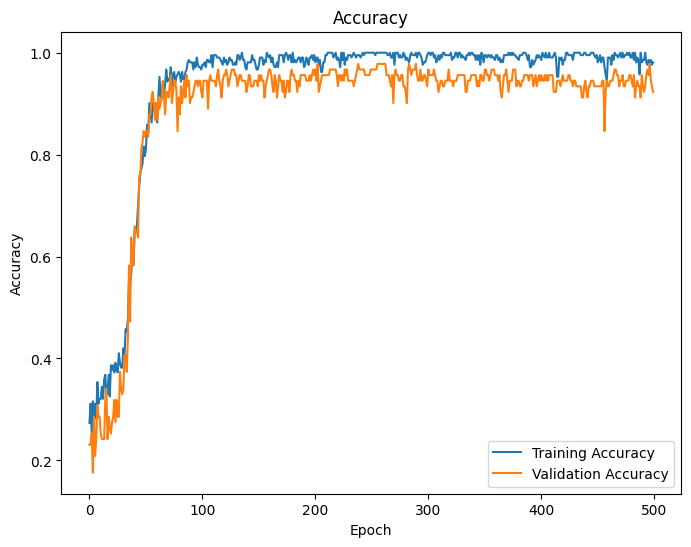

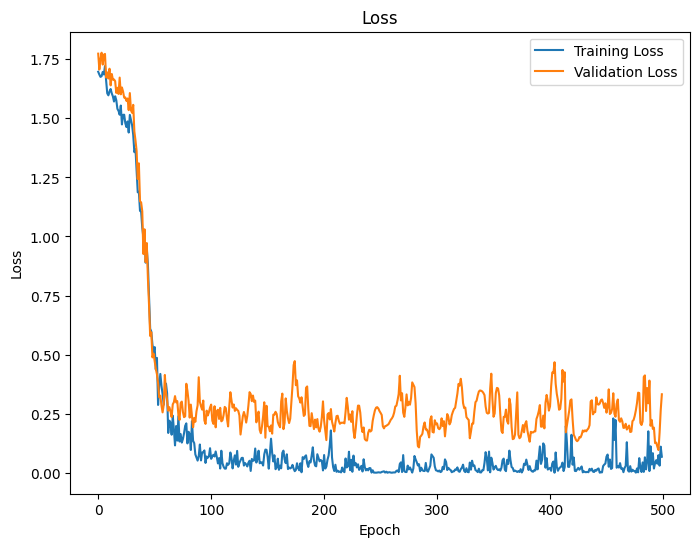

In [72]:
# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

4. #### Save the model

In [73]:
!rm -r models
!mkdir models

rm: models: No such file or directory


In [74]:
model.save("models/cnn-vgg.hdf5")

In [75]:
!ls -lh models

total 116744
-rw-r--r--  1 gracialukelo  staff    57M 23 Jun 13:29 cnn-vgg.hdf5


In [76]:
del model

5. #### Load the model

In [79]:
import tensorflow as tf

In [80]:
model = tf.keras.models.load_model("models/cnn-vgg.hdf5")

In [81]:
import random

# Pick 10 random images for test data set
random.seed(3) # to make this deterministic
sample_indexes = random.sample(range(len(X_test)), 10)
sample_images = [X_test[i] for i in sample_indexes]
sample_labels = [y_test[i] for i in sample_indexes]

ground_truth = np.argmax(sample_labels, axis=1)

X_sample = np.array(sample_images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)
predicted_categories

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


array([5, 2, 0, 5, 0, 5, 2, 1, 0, 5])

In [82]:
# Display the predictions and the ground truth visually.
def display_prediction (images, true_labels, predicted_labels):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(true_labels)):
        truth = true_labels[i]
        prediction = predicted_labels[i]
        plt.subplot(5, 2,1+i)
        plt.axis('off')
        color='green' if truth == prediction else 'red'
        plt.text(80, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
                 fontsize=12, color=color)
        plt.imshow(images[i])

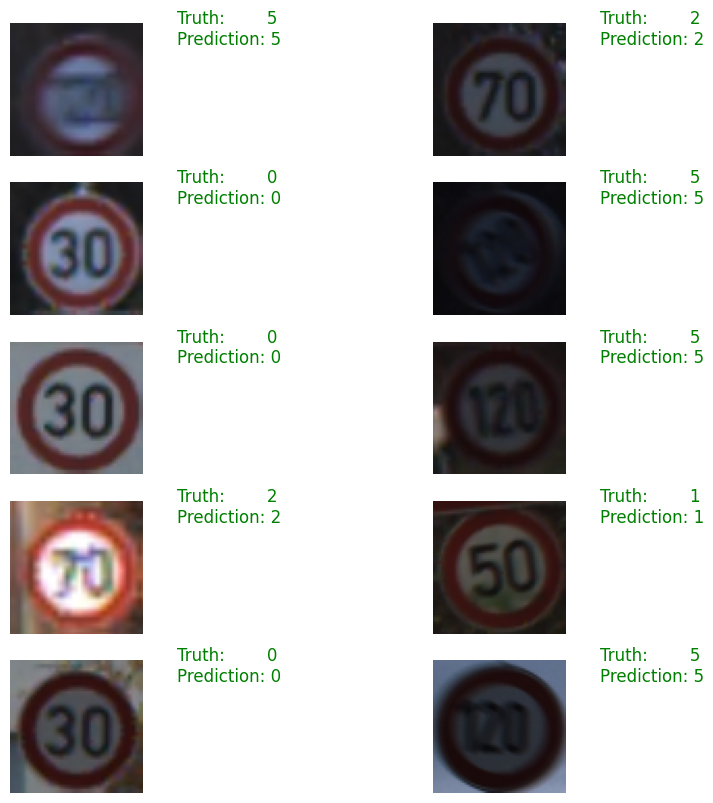

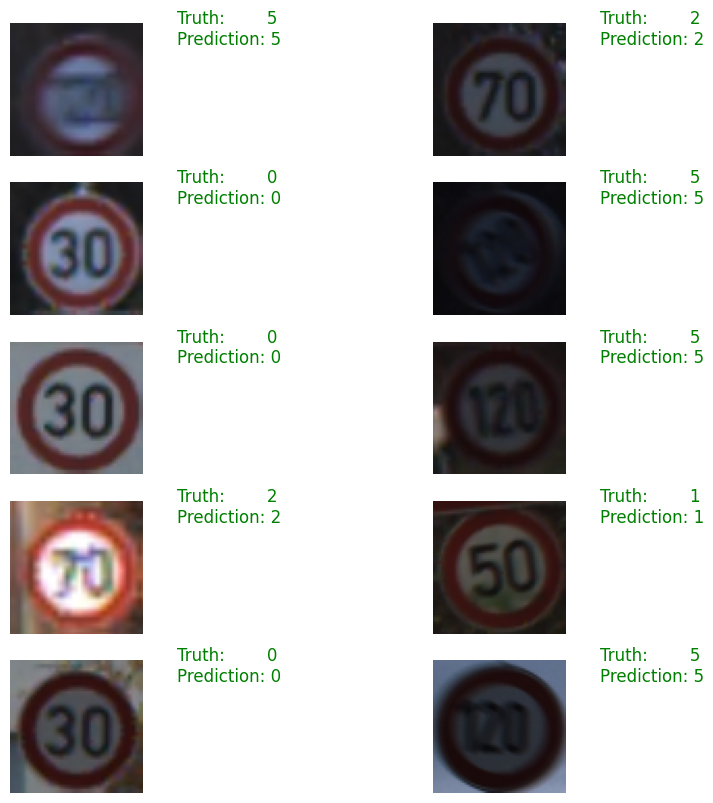

In [84]:
display_prediction(sample_images, ground_truth, predicted_categories)
plt.show()